In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import numpy as np

from typing import Union, List, Tuple

/home/philip/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
class CausalConv1d(nn.Conv1d):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.causal_padding = self.dilation[0] * (self.kernel_size[0]-1)
        
    def forward(self, x):
        px = F.pad(x, [self.causal_padding, 0])
        return self._conv_forward(px, self.weight, self.bias)

# derived from https://github.com/wesbz/SoundStream/blob/main/net.py
class CausalConvTranspose1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, **kwargs):
        
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.causal_padding = kernel_size - 1
        
        self.conv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, **kwargs)

    def forward(self, x):
        n = x.shape[-1]
        out = self.conv(x)
        out = out[..., :(n * self.stride)] # remove padding from right

        return out

In [4]:
class SSResidualUnit(nn.Module):
    
    def __init__(self, channels:int, dilation:int):
        
        super(SSResidualUnit, self).__init__()
        
        self.channels = channels
        self.dilation = dilation
        
        self.sequence = nn.Sequential(
            CausalConv1d(in_channels=channels, out_channels=channels, kernel_size=7, dilation=dilation),
            nn.ELU(),
            nn.Conv1d(channels, channels, kernel_size=1)
        )
        
    def forward(self, x):
        h = self.sequence(x)
        return x + h
    
s = SSResidualUnit(2, 7)
x = torch.randn((1, 2, 64))
s.sequence[0](x).shape

torch.Size([1, 2, 64])

In [5]:
class SSEncoderBlock(nn.Module):
    
    def __init__(self, channels:int, stride:int):
        
        super(SSEncoderBlock, self).__init__()
        
        self.channels = channels
        self.stride = stride
        
        self.resid_0 = SSResidualUnit(self.channels // 2, dilation = 1)
        self.resid_1 = SSResidualUnit(self.channels // 2, dilation = 3)
        self.resid_2 = SSResidualUnit(self.channels // 2, dilation = 9)
        self.activation = nn.ELU()
        
        self.out_conv = CausalConv1d(in_channels=self.channels // 2, out_channels=self.channels, kernel_size=2*self.stride, stride=self.stride)
        
    def forward(self, x):
        x0 = self.activation(self.resid_0(x))
        x1 = self.activation(self.resid_0(x0))
        x2 = self.activation(self.resid_0(x1))
        out = self.out_conv(x2)
        
        return out
    
se = SSEncoderBlock(4, 2)
x = torch.randn((1, 2, 4096))
se(x).shape

torch.Size([1, 4, 2048])

In [6]:
class SSEncoder(nn.Module):
    
    def __init__(self, in_channels:int, channels:int, embedding_dims:int):
        
        super(SSEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.channels = channels
        self.embedding_dims = embedding_dims
        
        self.in_conv = CausalConv1d(in_channels=self.in_channels, out_channels=self.channels, kernel_size=7)
        
        self.encoder_block_0 = SSEncoderBlock(self.channels * 2, 2)
        self.encoder_block_1 = SSEncoderBlock(self.channels * 4, 4)
        self.encoder_block_2 = SSEncoderBlock(self.channels * 8, 5)
        self.encoder_block_3 = SSEncoderBlock(self.channels * 16, 8)
        self.activation = nn.ELU()
        
        self.out_conv = CausalConv1d(in_channels=self.channels * 16, out_channels=self.embedding_dims, kernel_size=3)
        
    def forward(self, x):
        
        h = self.activation(self.in_conv(x))
        h0 = self.activation(self.encoder_block_0(h))
        h1 = self.activation(self.encoder_block_1(h0))
        h2 = self.activation(self.encoder_block_2(h1))
        h3 = self.activation(self.encoder_block_3(h2))
        
        out = self.out_conv(h3)
        
        return out
    
sse = SSEncoder(1, 4, 128)
sse(torch.randn(1, 1, 44100)).shape

torch.Size([1, 128, 138])

In [7]:
class SSDecoderBlock(nn.Module):
    
    def __init__(self, channels:int, stride:int):
        
        super(SSDecoderBlock, self).__init__()
        
        self.channels = channels
        self.stride = stride
        
        self.in_conv = CausalConvTranspose1d(in_channels=2*self.channels, out_channels=self.channels, kernel_size=2*self.stride, stride=self.stride)
        
        self.resid_0 = SSResidualUnit(self.channels, dilation = 1)
        self.resid_1 = SSResidualUnit(self.channels, dilation = 3)
        self.resid_2 = SSResidualUnit(self.channels, dilation = 9)
        self.activation = nn.ELU()
        
    def forward(self, x):
        x0 = self.activation(self.in_conv(x))
        x1 = self.activation(self.resid_0(x0))
        x2 = self.activation(self.resid_1(x1))
        out = self.resid_2(x2)
        
        return out
    
se = SSDecoderBlock(8, 2)
x = torch.randn((1, 16, 64))
se(x).shape

torch.Size([1, 8, 128])

In [8]:
class SSDecoder(nn.Module):
    
    def __init__(self, out_channels:int, channels:int, embedding_dims:int):
        
        super(SSDecoder, self).__init__()
        
        self.out_channels = out_channels
        self.channels = channels
        self.embedding_dims = embedding_dims
        
        self.in_conv = CausalConv1d(in_channels=self.embedding_dims, out_channels=self.channels * 16, kernel_size=7, stride=1)
        
        self.encoder_block_0 = SSDecoderBlock(self.channels * 8, 8)
        self.encoder_block_1 = SSDecoderBlock(self.channels * 4, 5)
        self.encoder_block_2 = SSDecoderBlock(self.channels * 2, 4)
        self.encoder_block_3 = SSDecoderBlock(self.channels, 2)
        self.activation = nn.ELU()
        
        self.out_conv = CausalConv1d(in_channels=self.channels, out_channels=self.out_channels, kernel_size=7)
        
        
    def forward(self, x):
        
        h = self.activation(self.in_conv(x))
        h0 = self.activation(self.encoder_block_0(h))
        h1 = self.activation(self.encoder_block_1(h0))
        h2 = self.activation(self.encoder_block_2(h1))
        h3 = self.activation(self.encoder_block_3(h2))
        out = self.out_conv(h3)
        
        return out
    
dec = SSDecoder(1, 8, 512)
x = torch.randn((1, 512, 51))
dec(x).shape

torch.Size([1, 1, 16320])

In [80]:
clamped_log = lambda x: torch.log(x.clamp(min = 1e-20))

def gumbel_noise(t):
    noise = torch.zeros_like(t).uniform_(0, 1)
    return -clamped_log(-clamped_log(noise))

def gumbel_sample(t, temperature = 1., dim = -1):
    if temperature == 0:
        return t.argmax(dim = dim)

    return ((t / temperature) + gumbel_noise(t)).argmax(dim = dim)

gumbel_sample(torch.randn(3,52,128), dim=-1)

tensor([[ 30,  61,  54,  79,  42, 117,  84,   8,  17,  60,  76, 109,  47,  26,
          86,  81,  83,  34,  30, 108, 119, 102,  44,  54,  91,  92,  93,  14,
          58,  53, 116,  34,  35,  90,  29,   0,  90,  57,  13,  43,  58,  97,
          18,  43,  66,  65, 104,  65,  66,  73,  78, 123],
        [ 63,  66,  33,  10,  16, 114, 120,  11, 100,  57,   7,  26,  51,  72,
         106,  50,   6,  58, 101,  17,   4,  92, 117,  65,  19,   0,   0,  36,
          64,  82,  94,  44,   4,  73, 125,  71,  89,  15,  27,  58,  57,  75,
         117,  38,  37,  25, 127,  85,  95,  33,  36, 117],
        [ 54,  29, 102,  99,  10,  31,  64, 109, 123,  18,  80,  33,  39,  34,
          73,  75, 105, 127, 124,   3,  92,  74,   8,  68, 117,  80,   6, 125,
          56, 108,  67, 103,  18, 117,  99, 118,   4, 127, 100,  78,  36,  44,
         116,  99,  26, 112,  41,  92,  92,  40,  72,  16]])

In [90]:

class EmbeddingQuantizer(nn.Module):

    def __init__(self, codebook_size:int, embedding_dims:int, gumbel_sample:bool=True) -> None:
        
        super(EmbeddingQuantizer, self).__init__()

        self.embedding_dims = embedding_dims
        self.codebook_size = codebook_size
        self.gumbel_sample = gumbel_sample

        self.embeddings = nn.Embedding(self.codebook_size, self.embedding_dims)
        
        self.embeddings.apply(self._init_weights)
        
    def _init_weights(self, m):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, x):

        B, C, T = x.shape

        reshape_inputs = x.permute(0, 2, 1).contiguous() # embed by channel values (BTC)
        reshape_inputs = reshape_inputs.view(-1, self.embedding_dims) # reshape to embedding dimensions (B, E)

        # calculate distances between all inputs and embeddings
        if self.gumbel_sample:
            distances = -torch.cdist(reshape_inputs, self.embeddings.weight)
            embedding_indexes = gumbel_sample(distances)
        else:
            xs = (reshape_inputs**2).sum(dim=1, keepdim=True)
            ys = (self.embeddings.weight**2).sum(dim=1)
            dots = reshape_inputs @ self.embeddings.weight.t()
            distances = (xs + ys) - (2 * dots)
            embedding_indexes = torch.argmin(distances, dim=1).unsqueeze(1)
        

        # get embedding indices and quantize
        quantized_embeddings = self.embeddings(embedding_indexes).view(B, T, C).permute(0, 2, 1).contiguous()

        loss = F.mse_loss(x, quantized_embeddings)

        return quantized_embeddings, embedding_indexes.squeeze(-1), loss
    
    
class ResidualEmbeddingQuantizer(nn.Module):
    
    def __init__(self, codebook_size:int, embedding_dims:int, total_codebooks:int, gumbel_sample:bool=True) -> None:
        
        super(ResidualEmbeddingQuantizer, self).__init__()
        
        self.embedding_dims = embedding_dims
        self.codebook_size = codebook_size
        self.total_codebooks = total_codebooks
        
        self.codebooks = nn.Sequential(*[EmbeddingQuantizer(self.codebook_size, self.embedding_dims, gumbel_sample) for _ in range(self.total_codebooks)])
        
    def forward(self, x):
        
        y_hat = torch.zeros_like(x).to(x.device)
        cumulative_loss = torch.tensor(0.).to(x.device)
        all_codes = []
        
        for codebook in self.codebooks:
            residual_embs, codes, loss = codebook(x)
            y_hat = y_hat + residual_embs
            x = x - residual_embs
            cumulative_loss += loss
            all_codes.append(codes)
        
        all_codes = torch.cat(all_codes).view(len(all_codes),-1)
            
        return y_hat, all_codes, cumulative_loss
        
        
    

eq = ResidualEmbeddingQuantizer(1024, 128, 5)
x = torch.randn((1, 128, 51))
embs, codes, loss = eq(x)
embs.shape, codes.shape, loss

(torch.Size([1, 128, 51]),
 torch.Size([5, 51]),
 tensor(4.9090, grad_fn=<AddBackward0>))

In [91]:
class SoundStream(nn.Module):
    
    def __init__(self, in_channels:int, channels:int, embedding_dims:int, codebook_size:int, total_codebooks:int):
        
        super(SoundStream, self).__init__()
        
        self.encoder = SSEncoder(in_channels, channels, embedding_dims)
        self.quantizer = ResidualEmbeddingQuantizer(codebook_size, embedding_dims, total_codebooks)
        self.decoder = SSDecoder(in_channels, channels, embedding_dims)
        
    def forward(self, x):
        
        h = self.encoder(x)
        embs, codes, q_loss = self.quantizer(h)
        out = self.decoder(embs)
        
        return out, embs, codes, q_loss
    
model = SoundStream(1, 4, 128, 512, 5)
x = torch.randn(1, 1, 22080)
out, embs, codes, q_loss = model(x)
x.shape, out.shape, embs.shape, codes, q_loss

(torch.Size([1, 1, 22080]),
 torch.Size([1, 1, 22080]),
 torch.Size([1, 128, 69]),
 tensor([[237, 114, 385, 118, 235,   9, 336, 343, 287, 117,  20,   8,  82,  42,
          196, 347, 360, 155, 252,  36, 449, 159, 335, 485, 139, 102, 113, 372,
          146, 408,   5, 482, 175, 214, 402,   5,  77,  56,  91,  94, 199, 173,
           31, 380,  28, 114, 432, 170,  71, 145, 373, 159,  32, 355, 147,   1,
          226, 100, 154, 395, 195, 479, 368, 291, 183, 502, 363, 129, 180],
         [128,   6, 492, 233, 444, 193, 412, 213, 176, 254, 146, 463, 192, 354,
           58, 470, 389, 265, 278, 402, 335, 338, 112, 132, 188, 428, 461, 398,
          128, 249, 433, 457, 435, 299, 105,  79, 178,  66, 150, 273,   8, 157,
          154, 105, 466, 447, 282, 424, 210, 263, 158,  28, 330, 433,  39, 492,
          403, 497,  22, 165, 286, 496, 444, 488, 446,  50, 476, 447, 246],
         [502, 456, 262, 464,  24, 489, 260, 410, 423, 264,  14,  62, 129, 272,
          494, 430, 431, 241, 291, 168, 320, 

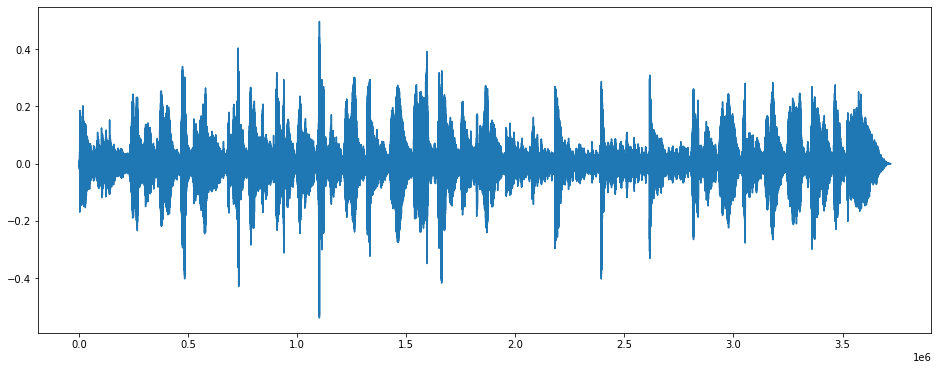

In [30]:
# not using stft for now
import librosa

x, sr = librosa.load('../data/song_01.wav', sr=22080)

plt.figure(figsize=(16,6))
plt.plot(x)

In [31]:
sample_size = sr * 2
x = torch.tensor(x)
cutoff = x.shape[0] - (x.shape[0] % sample_size)
xs = x[:cutoff].view(-1, sample_size)
xs = xs[:,None,...]
xs.shape

torch.Size([84, 1, 44160])

In [13]:
out = model(xs[:3])[0]
out.shape

torch.Size([3, 1, 44160])

torch.Size([44160])

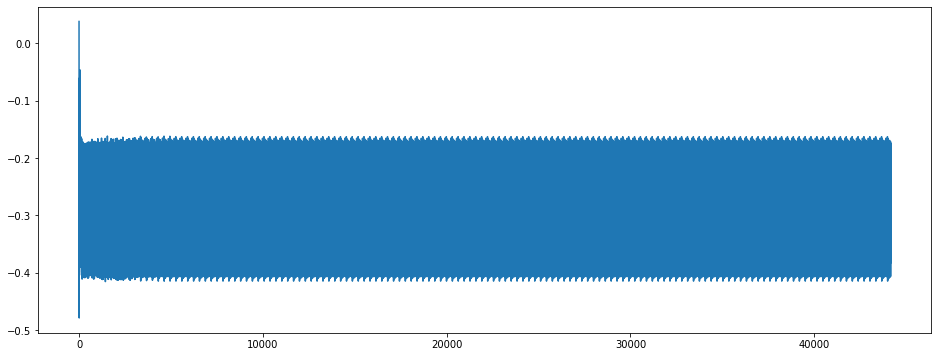

In [14]:
plt.figure(figsize=(16,6))
untrained_sample = out[1].squeeze().detach()
plt.plot(untrained_sample)
untrained_sample.shape

In [24]:
from IPython.display import Audio

Audio(xs[61].squeeze().tolist(), rate=sr)

In [92]:
device = "cuda:1"
model = SoundStream(1, 4, 256, 1024, 8)
model.to(device)

criterion = F.mse_loss
optimizer = torch.optim.Adam(model.parameters())
steps = 100
pbar = tqdm(total=steps)
losses = []
BATCH_SIZE = 32

for i in range(steps):
    pbar.update(1)
    batch_ix = torch.randint(0, xs.shape[0], (BATCH_SIZE,))
    inputs = xs[batch_ix].to(device)
    out, embs, codes, q_loss = model(inputs)

    #sc_loss, mag_loss = criterion(out.squeeze(), inputs.squeeze())
    #loss = q_loss + sc_loss + mag_loss
    recon_loss = criterion(out.squeeze(), inputs.squeeze())
    loss = recon_loss + q_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    pbar.set_description(desc=f"average loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

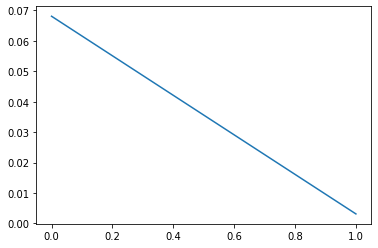

In [70]:
plt.plot(torch.tensor(losses).view(-1, 50).mean(1))

In [93]:
sample_ix = 61
out, embs, codes, q_loss =  model(xs[sample_ix][None,...].to(device))
Audio(out.squeeze().tolist(), rate=sr)

In [268]:
Audio(xs[sample_ix].squeeze().tolist(), rate=sr)

In [269]:
out.squeeze()[:30], xs[sample_ix].squeeze()[:30]

(tensor([-0.0462, -0.1092, -0.1126, -0.0676, -0.0874, -0.0692, -0.0489, -0.0464,
         -0.0432, -0.0507, -0.0357, -0.0187, -0.0235, -0.0301, -0.0307, -0.0335,
         -0.0124, -0.0108, -0.0257,  0.0169,  0.0243, -0.0010, -0.0078, -0.0061,
         -0.0010,  0.0130,  0.0148,  0.0075,  0.0277,  0.0332], device='cuda:1',
        grad_fn=<SliceBackward0>),
 tensor([-0.1246, -0.1639, -0.1689, -0.1416, -0.1092, -0.1010, -0.1144, -0.1262,
         -0.1306, -0.1281, -0.1280, -0.1357, -0.1469, -0.1481, -0.1283, -0.0942,
         -0.0480, -0.0027,  0.0301,  0.0475,  0.0361,  0.0129, -0.0062, -0.0248,
         -0.0343, -0.0356, -0.0359, -0.0413, -0.0476, -0.0475]))